# How to pass additional arguments into tools

"Tools" are functions you expose to a language model.

Typically there is a one-to-one relationship between the function's **developer interface** and its "**agent interface**". Your search tool needs a query string, and that's how you represent it to the LLM (via `bind_tools`).

Just as with traditional web APIs, the interface may expose only a subset of the required parameters. For example, the bot normally isn't responsible with providing a user_id for database access. That should be provided via configuration when a user authenticates to your service.

This guide shows how to provide additional parameters to a tool from either the **state** or the **configuration.**


## How to access other state variables within a tool

A common example of this would be if you retrievee a set of documents and need to process them in some way. It's untenable to ask the llm to regurgitate each document and pass them by value for the tool.

Instead, we'll split the tool as an **interface** and a separate **function**.

In [ ]:
%%capture --no-stderr
%pip install -U langchain-anthropic

In [1]:
import re
from typing import Callable, Literal, Optional

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from typing_extensions import Annotated, TypedDict

from langgraph.graph import END, START, StateGraph, add_messages


# ******************************************************************************************
# THIS IS THE MAIN CHANGE! Define a separate agent interface than whatever is expected by your tool
# We define an interface as a base model (Can also use a schema dict, other function, etc.)
class SearchDocs(BaseModel):
    """Search the retrieved docs using a regex match."""

    regex: str = Field(description="The regex to use when searching the docs")


# And then we define the function interface here
async def docs_contain(regex: str, docs: list[dict]) -> list[str]:
    """Search the docs."""
    return [doc["id"] for doc in docs if bool(re.search(regex, doc["page_content"]))]


# ******************************************************************************************


# If you want to tightly couple the interface and implementation, you can bundle schemas & implementations
# as a struct like the following
# You could also unit test things like "assert each schema is exactly a subset of its corresponding tool"
class ScopedTool:
    def __init__(self, fn: Callable, scoped_schema: Optional[BaseModel] = None):
        self.name = scoped_schema.__name__ if scoped_schema else fn.__name__
        self.tool = tool(self.name)(fn)
        self.schema = scoped_schema if scoped_schema else self.tool.args_schema


search_tool = ScopedTool(docs_contain, SearchDocs)

scoped_tools = [search_tool]
tools_by_name = {t.name: t.tool for t in scoped_tools}
# ******************************************************************************************


# Define the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    docs: list[dict]


async def retrieve(state: State):
    # Fake retrieval step to illustrate
    # state variables you'd want to access within a tool
    return {
        "docs": [
            {"id": "doc-1", "page_content": "Send to johnny.bravo@langchain.ai"},
            {
                "id": "doc-2",
                "page_content": "Do you have a moment to talk about car insurance?",
            },
        ]
    }


async def agent(state: State, config: RunnableConfig):
    llm = ChatAnthropic(model="claude-3-5-sonnet-20240620").bind_tools(
        [t.schema for t in scoped_tools]
    )
    msg = await llm.ainvoke(
        [("system", "You are a helpful assistant who uses tools")] + state["messages"],
        config,
    )
    return {"messages": [msg]}


async def execute_tools(state: State):
    tool_calls = state["messages"][-1].tool_calls
    responses = []
    for tc in tool_calls:
        output = await tools_by_name[tc["name"]].ainvoke({**tc["args"], **state})
        responses.append(
            ToolMessage(content=str(output), name=tc["name"], tool_call_id=tc["id"])
        )
    return {"messages": responses}


builder = StateGraph(State)
builder.add_node(retrieve)
builder.add_node(agent)
builder.add_node(execute_tools)


def route_tools(state: State) -> Literal["execute_tools", "__end__"]:
    if state["messages"][-1].tool_calls:
        return "execute_tools"
    return END


builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "agent")
builder.add_conditional_edges("agent", route_tools)
builder.add_edge("execute_tools", "agent")
graph = builder.compile()

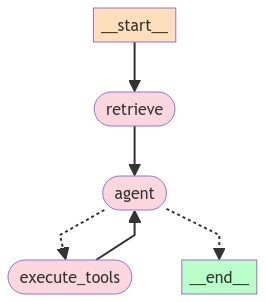

In [2]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [3]:
async for stream_event in graph.astream_events(
    {"messages": [("user", "What docs contain an email address?")]}, version="v2"
):
    if (event := stream_event.get("event")) and event == "on_chat_model_stream":
        chunk = stream_event["data"]["chunk"]
        if chunk.content and (text := chunk.content[0].get("text")):
            print(text, end="")

/Users/wfh/.pyenv/versions/3.11.2/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


To find documents that contain an email address, we can use the SearchDocs function with a regular expression pattern that matches email addresses. Let's use a common regex pattern for email addresses and search the documents.

Based on the search results, it appears that the document "doc-1" contains an email address.

The regex pattern I used ([a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}) is designed to match most common email address formats. It looks for:

1. One or more characters that can be letters, numbers, or certain special characters before the @ symbol
2. The @ symbol
3. One or more characters that can be letters, numbers, or certain special characters after the @ symbol
4. A dot (.)
5. Two or more letters at the end (for the top-level domain)

This pattern should catch most standard email addresses. If you need more specific information about the email addresses found or want to search for a particular type of email address, please let me know, and I can adjust the searc

## How to access configuration within a tool

For more common use cases, like passing user IDs in, you can simply pass it via **configuration**.

Here is an example.

In [4]:
import re
from typing import Callable, Literal, Optional, Sequence

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnableConfig, ensure_config
from langchain_core.tools import tool
from typing_extensions import Annotated, TypedDict

from langgraph.graph import END, START, StateGraph, add_messages
from langgraph.prebuilt import ToolNode

emails = {
    "user_a": [
        {
            "id": "doc-1",
            "from": "lex@nunya.co",
            "body": "We've been discovered. Alert johnny.bravo@langchain.ai",
        },
    ],
    "user_b": [
        {
            "id": "doc-2",
            "from": "jake@fedfarm.com",
            "body": "Do you have a moment to talk about car insurance?",
        }
    ],
}


@tool
async def search_email(
    patterns: list[str], fields_to_check: Sequence[Literal["from", "body"]]
) -> list[str]:
    """Search the docs using a regex. Can check either the from field or the message body."""
    config = ensure_config()
    user_id = config["configurable"]["user_id"]
    docs = emails.get(user_id) or []
    res = []
    for doc in docs:
        added = False
        for field in fields_to_check:
            if added:
                break
            for regex in patterns:
                if re.search(regex, doc[field], flags=re.IGNORECASE):
                    added = True
                    res.append(doc)
                    break
    return res


tools = [search_email]


# Define the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    docs: list[dict]


async def agent(state: State, config: RunnableConfig):
    llm = ChatAnthropic(model="claude-3-5-sonnet-20240620").bind_tools(tools)
    msg = await llm.ainvoke(
        [("system", "You are a helpful assistant who uses tools.")] + state["messages"],
        config,
    )
    return {"messages": [msg]}


builder = StateGraph(State)
builder.add_node(agent)
builder.add_node(ToolNode(tools))


def route_tools(state: State) -> Literal["tools", "__end__"]:
    if state["messages"][-1].tool_calls:
        return "tools"
    return END


builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", route_tools)
builder.add_edge("tools", "agent")
graph = builder.compile()

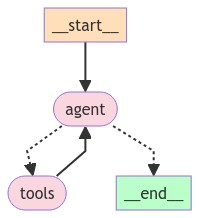

In [5]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [6]:
for user in ["user_a", "user_b"]:
    print(f"## Searching from the perspective of user: {user}")
    async for stream_event in graph.astream_events(
        {"messages": [("user", "Did lex email yet?")]},
        {"configurable": {"user_id": user}},
        version="v2",
    ):
        if (event := stream_event.get("event")) and event == "on_chat_model_stream":
            chunk = stream_event["data"]["chunk"]
            if chunk.content and (text := chunk.content[0].get("text")):
                print(text, end="")
    print("\n\n")
    print("*" * 80)

## Searching from the perspective of user: user_a
To answer your question about whether Lex has emailed yet, I'll need to search the email records for any messages from Lex. Let me use the search_email function to check for this.

Based on the search results, it appears that Lex has indeed emailed. There is an email from "lex@nunya.co" in the records. 

The email contains a message that says: "We've been discovered. Alert johnny.bravo@langchain.ai"

It seems that Lex sent an email with some urgent information. Is there anything specific you'd like to know about this email or any further questions you have?


********************************************************************************
## Searching from the perspective of user: user_b
To answer your question about whether Lex has emailed yet, I'll need to search the email records. I can use the search_email function to look for emails from Lex. Let me do that for you.

Based on the search results, it appears that there are no emails 